## Defining Noisy Environment ##

In [1]:
from tqdm import tqdm
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

In [2]:
from sklearn.model_selection import train_test_split
mndata = MNIST('data')
x_train_data, y_train_data = mndata.load_training()
X_train, X_val, y_train, y_val = train_test_split(x_train_data, y_train_data, test_size=0.1, random_state=42)

training_steps=50000
checkpoint_loss=1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

class NoisyMnistEnv:
    def __init__(self, split, input_number_min, input_number_max, batch_size=32, seed=0):
        self.seed = seed
        self.split = split
        if self.split == "train":
            self.x, self.y = X_train, y_train
        elif self.split == "val":
            self.x, self.y = X_val, y_val
        self.batch_size = batch_size
        self.input_number_min = input_number_min
        self.input_number_max = input_number_max
        
    
    def step(self):
        x_arr = np.zeros((self.batch_size, 28 * 28))
        y_arr = np.zeros((self.batch_size, 28 * 28))

        for i in range(self.batch_size):
            input_number = np.random.randint(self.input_number_min, self.input_number_max)
            if input_number == 0:
                output_number = 0
            if input_number == 1:
                output_number = np.random.randint(2, 10)
            input_data = self.get_random_sample_of_number(input_number)
            if input_number == 1:
                output_data = self.get_random_sample_of_number(output_number)
            elif input_number == 0:
                output_data = input_data
            x_arr[i] = np.array(input_data)
            y_arr[i] = np.array(output_data)
        return x_arr, y_arr
    
    def get_random_sample_of_number(self, number):
        random_num = np.random.randint(0, len(self.y) - 1)
        if self.y[random_num] == number:
            return self.x[random_num]
        else:
            return self.get_random_sample_of_number(number)

device: cuda


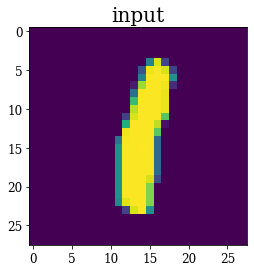

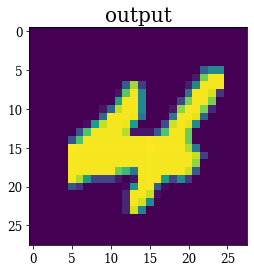

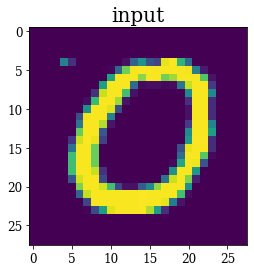

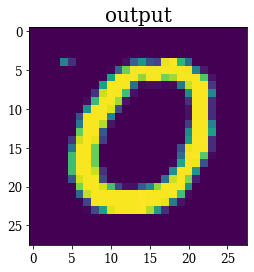

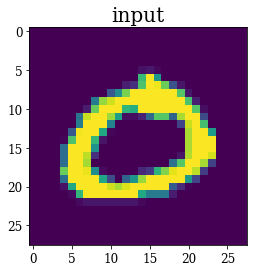

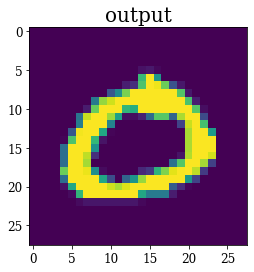

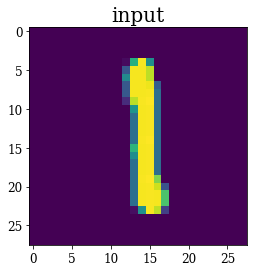

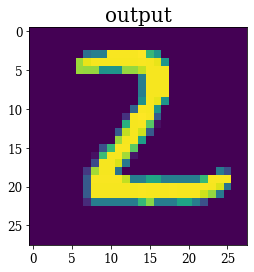

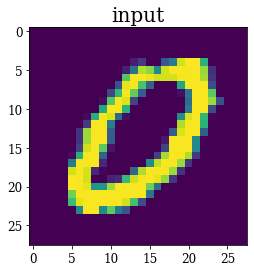

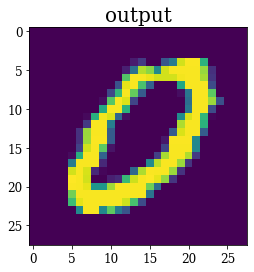

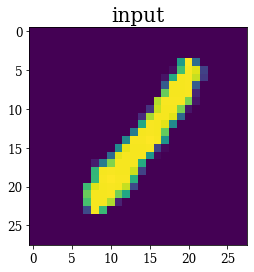

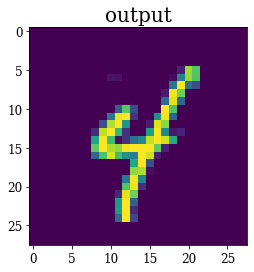

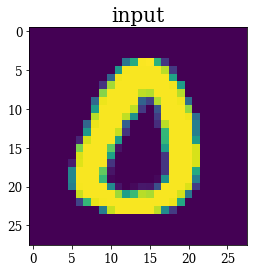

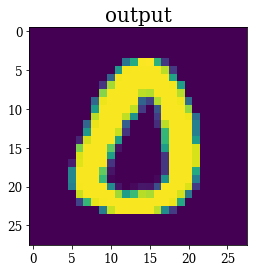

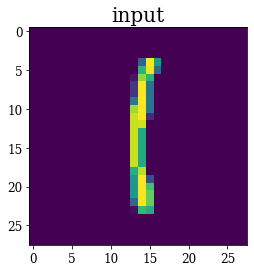

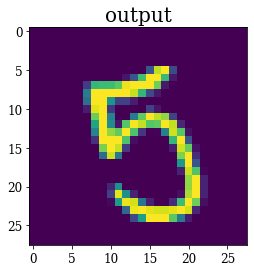

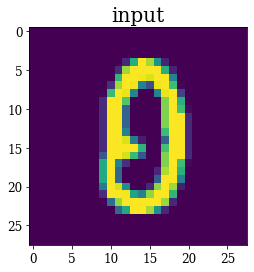

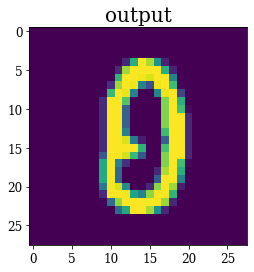

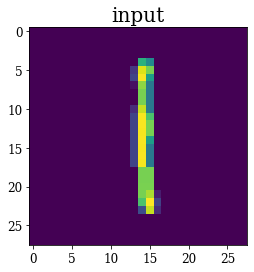

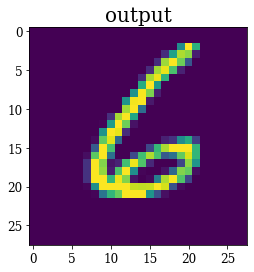

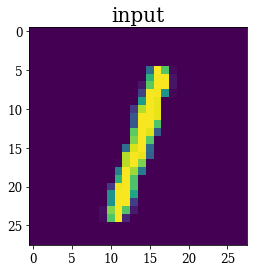

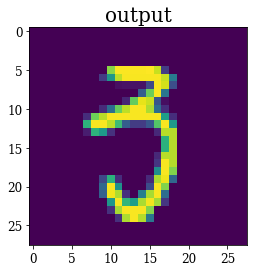

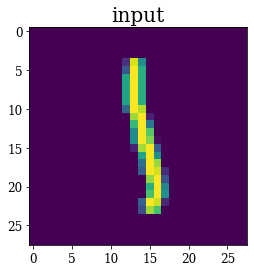

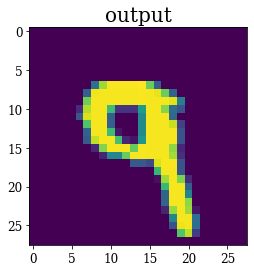

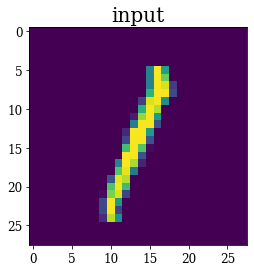

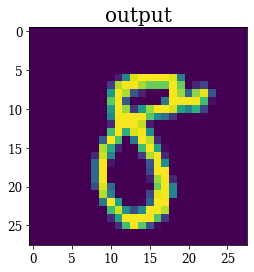

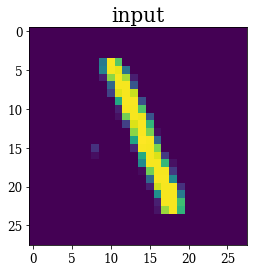

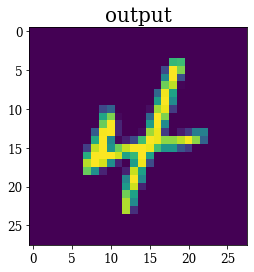

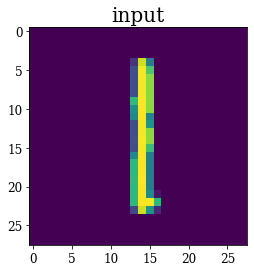

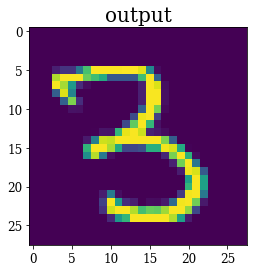

In [3]:
mnist_env = NoisyMnistEnv("val", 0, 2)
x, y  = mnist_env.step()
count = 0
for i in zip(x,y):
    count += 1
    if count == 16:
        break
    plt.title("input", fontsize=20)
    plt.imshow(np.squeeze(i[0]).reshape(28, 28))
    plt.show()
    plt.title("output", fontsize=20)
    plt.imshow(np.squeeze(i[1]).reshape(28, 28))
    plt.show()

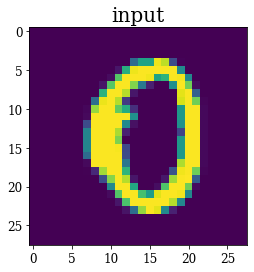

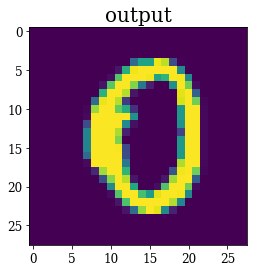

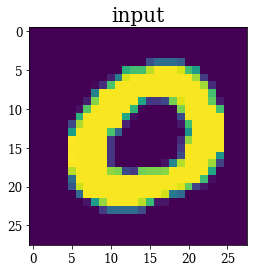

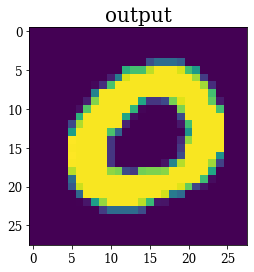

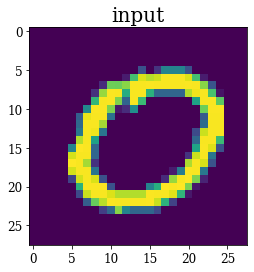

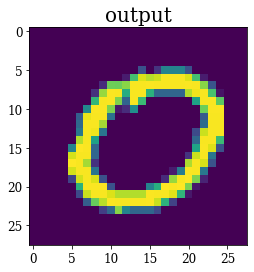

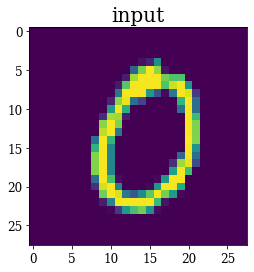

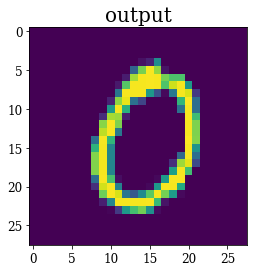

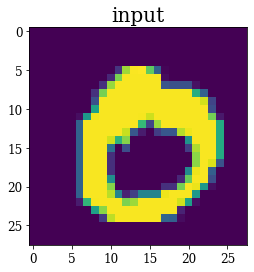

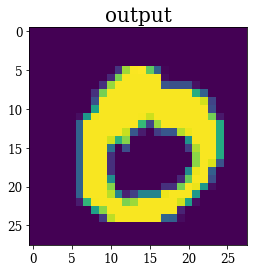

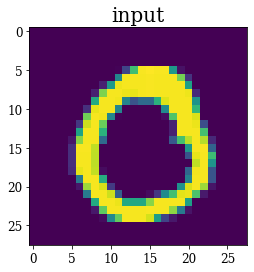

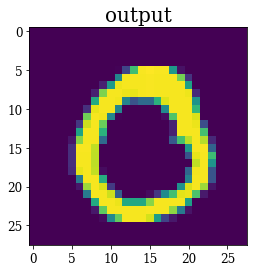

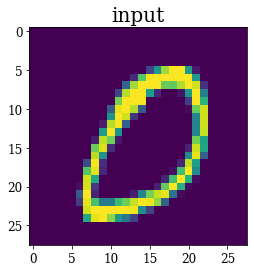

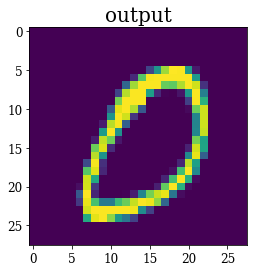

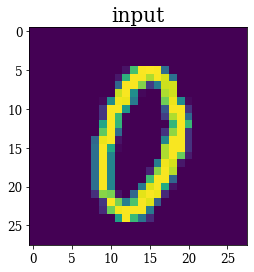

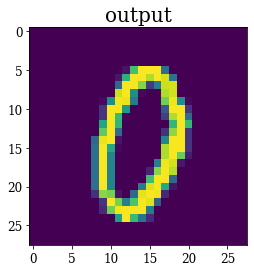

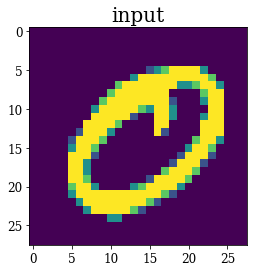

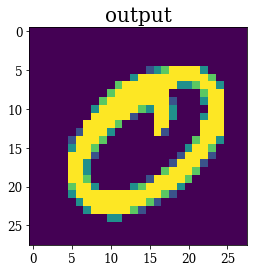

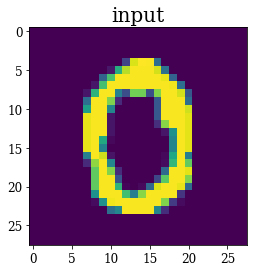

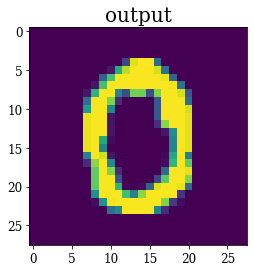

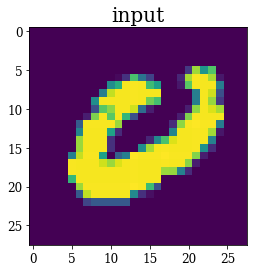

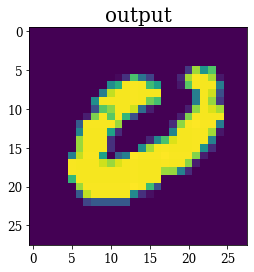

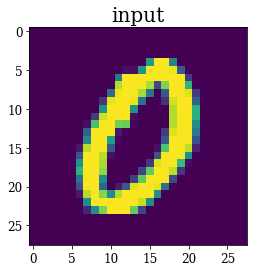

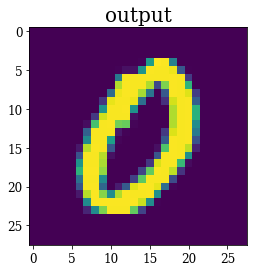

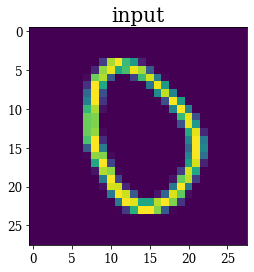

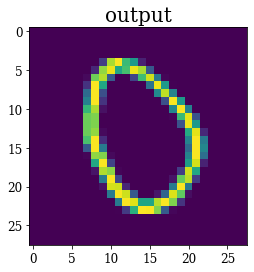

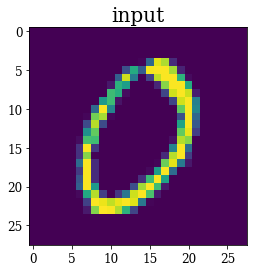

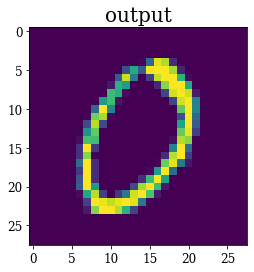

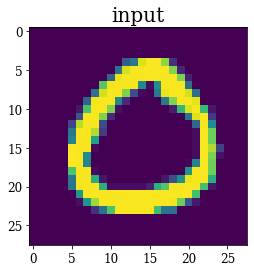

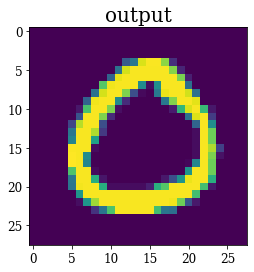

In [4]:
mnist_env_zeros = NoisyMnistEnv("val", 0, 1)
x, y  = mnist_env_zeros.step()
count = 0
for i in zip(x,y):
    count += 1
    if count == 16:
        break
    plt.title("input", fontsize=20)
    plt.imshow(np.squeeze(i[0]).reshape(28, 28))
    plt.show()
    plt.title("output", fontsize=20)
    plt.imshow(np.squeeze(i[1]).reshape(28, 28))
    plt.show()

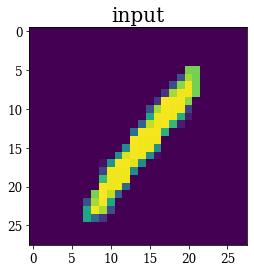

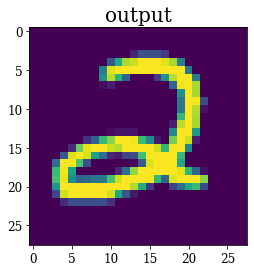

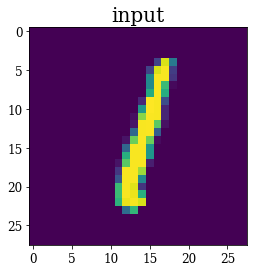

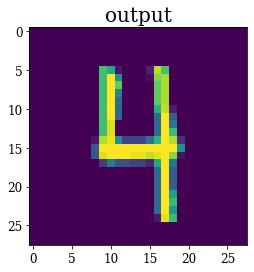

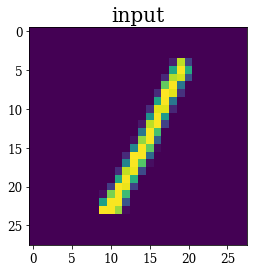

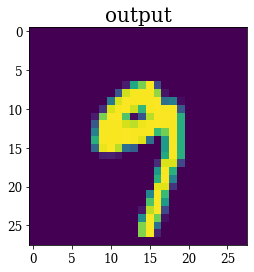

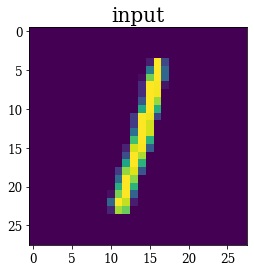

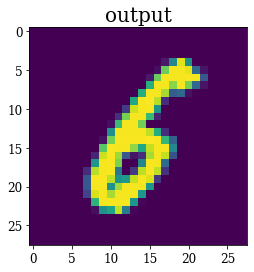

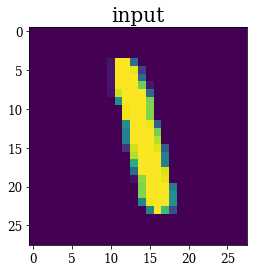

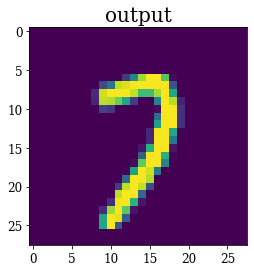

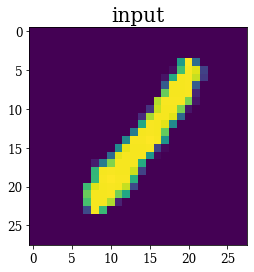

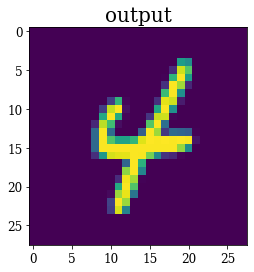

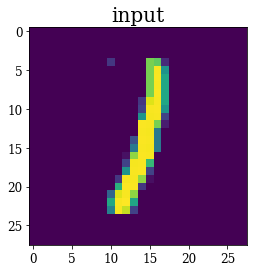

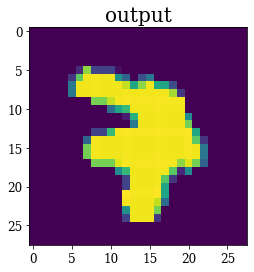

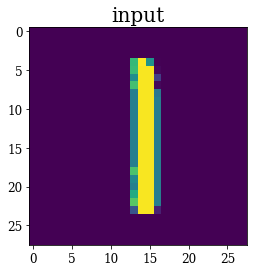

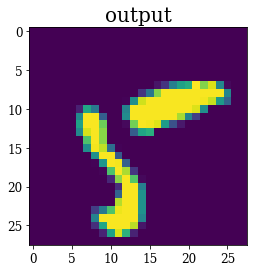

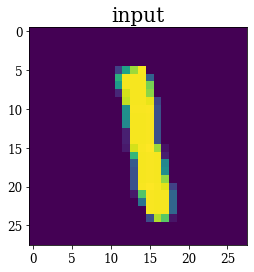

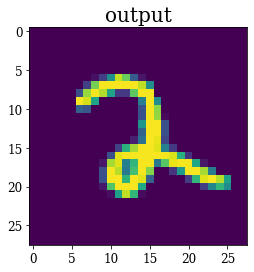

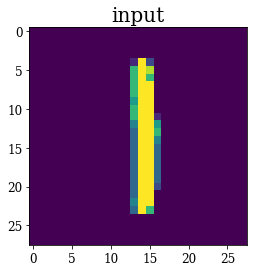

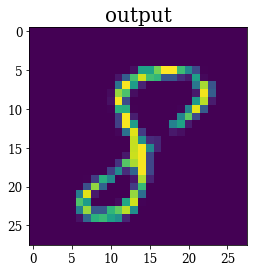

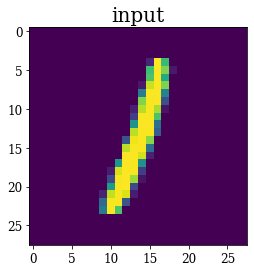

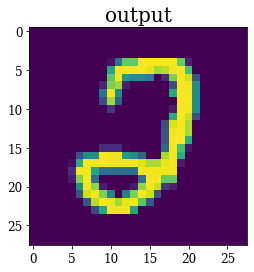

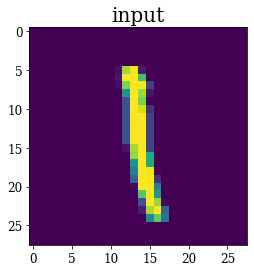

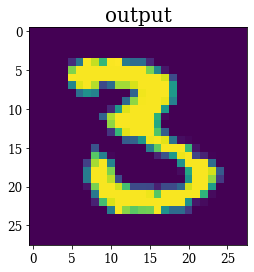

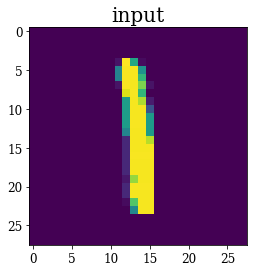

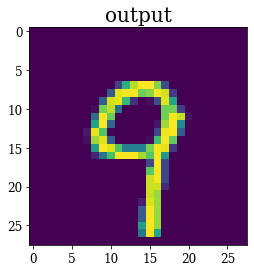

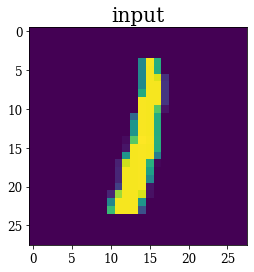

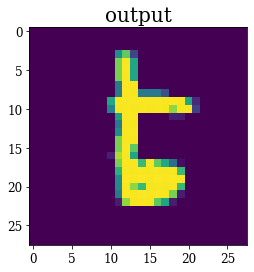

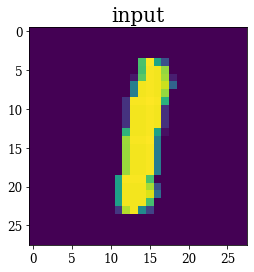

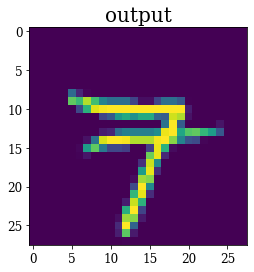

In [5]:
mnist_env_ones = NoisyMnistEnv("val", 1, 2)
x, y  = mnist_env_ones.step()
count = 0
for i in zip(x,y):
    count += 1
    if count == 16:
        break
    plt.title("input", fontsize=20)
    plt.imshow(np.squeeze(i[0]).reshape(28, 28))
    plt.show()
    plt.title("output", fontsize=20)
    plt.imshow(np.squeeze(i[1]).reshape(28, 28))
    plt.show()

## Defining Models ##

In [13]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# from here https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_1 = nn.Linear(28 * 28, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3 = nn.Linear(128, 128)
        self.linear_4 = nn.Linear(128, 28 * 28)
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = F.relu(self.linear_3(x))
        x = (self.linear_4(x))
        return x
    
# from here https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder
class AleatoricNet(nn.Module):
    def __init__(self):
        super(AleatoricNet, self).__init__()
        self.linear_1 = nn.Linear(28 * 28, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3_mu = nn.Linear(128, 128)
        self.linear_4_mu = nn.Linear(128, 28 * 28)
        self.linear_3_sigma = nn.Linear(128, 128)
        self.linear_4_sigma = nn.Linear(128, 28 * 28)
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        mu = F.relu(self.linear_3_mu(x))
        mu = (self.linear_4_mu(mu))
        log_sigma = F.relu(self.linear_3_sigma(x))
        log_sigma = (self.linear_4_sigma(log_sigma))
        return mu, log_sigma

### Vanilla ###

In [8]:
repeats = 3

for repeat in range(repeats):
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_list = []
    loss_buffer = []
    loss_list_0 = []
    loss_list_1 = []
    loss_buffer_0 = []
    loss_buffer_1 = []
    for update in tqdm(range(int(training_steps))):
        model.train()
        data, target = mnist_env.step()
        data /= 255
        target /= 255
        data = torch.from_numpy(data).float().to(device)
        target = torch.from_numpy(target).float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        loss_buffer.append(loss)
        if update % checkpoint_loss == 0:
            loss_list.append(torch.mean(torch.stack(loss_buffer)).detach().cpu().numpy())
            loss_buffer = []

        model.eval()
        data, target = mnist_env_zeros.step()
        data /= 255
        target /= 255
        data = torch.from_numpy(data).float().to(device)
        target = torch.from_numpy(target).float().to(device)
        output = model(data)
        loss_0 = F.mse_loss(output, target)
        loss_buffer_0.append(loss_0)
        if update % checkpoint_loss == 0:
            loss_list_0.append(torch.mean(torch.stack(loss_buffer_0)).detach().cpu().numpy())
            print("loss 0", torch.mean(torch.stack(loss_buffer_0)).detach().cpu().numpy())
            loss_buffer_0 = []
            
        model.eval()
        data, target = mnist_env_ones.step()
        data /= 255
        target /= 255
        data = torch.from_numpy(data).float().to(device)
        target = torch.from_numpy(target).float().to(device)
        output = model(data)
        loss_1 = F.mse_loss(output, target)
        loss_buffer_1.append(loss_1)
        if update % checkpoint_loss == 0:
            loss_list_1.append(torch.mean(torch.stack(loss_buffer_1)).detach().cpu().numpy())
            print("loss 1", torch.mean(torch.stack(loss_buffer_1)).detach().cpu().numpy())
            loss_buffer_1 = []

    data, target = mnist_env.step()
    predictions = model(torch.from_numpy(data).float().to(device)/255)

    for i in range(10):
        w=10
        h=10
        fig=plt.figure(figsize=(12, 12))
        columns = 3
        rows = 1
        fig.add_subplot(rows, columns, 1)
        plt.imshow(data[i].reshape(28, 28)/255, vmin=0, vmax=1)
        plt.title("input state", fontsize=20)

        fig.add_subplot(rows, columns, 2)
        plt.imshow(target[i].reshape(28, 28)/255, vmin=0, vmax=1)
        plt.title("true next state", fontsize=20)

        fig.add_subplot(rows, columns, 3)
        plt.imshow(predictions[i].detach().cpu().numpy().reshape(28, 28), vmin=0, vmax=1)
        plt.title("predicted $\mu$", fontsize=20)
        plt.show()
    
    np.save("lost_list_deterministic_" + str(repeat) + ".npy", loss_list_0)
    np.save("lost_list_stochastic_" + str(repeat) + ".npy", loss_list_1)

In [9]:
plt.plot(loss_list_0)
plt.plot(loss_list_1)

### Aleatoric ###


  0%|          | 6/50000 [00:00<15:34, 53.50it/s]

loss 0 -0.8515706
loss 1 -0.8784152



  2%|▏         | 900/50000 [00:16<14:52, 55.02it/s]


  2%|▏         | 1008/50000 [00:18<15:55, 51.25it/s]

loss 0 -0.024075907
loss 1 -0.02283938



  4%|▍         | 1884/50000 [00:34<14:26, 55.51it/s]


  4%|▍         | 2010/50000 [00:36<15:49, 50.52it/s]

loss 0 -0.00639564
loss 1 -0.007537271



  6%|▌         | 2886/50000 [00:52<14:15, 55.07it/s]


  6%|▌         | 3006/50000 [00:54<16:13, 48.26it/s]

loss 0 -0.0013287847
loss 1 -0.0051231594



  8%|▊         | 3882/50000 [01:10<13:50, 55.50it/s]


  8%|▊         | 4008/50000 [01:12<15:20, 49.95it/s]

loss 0 -0.00032957562
loss 1 -0.0072838394



 10%|▉         | 4884/50000 [01:28<13:30, 55.70it/s]


 10%|█         | 5010/50000 [01:30<15:00, 49.98it/s]

loss 0 -0.00070432975
loss 1 -0.003593157



 12%|█▏        | 5886/50000 [01:46<13:12, 55.67it/s]


 12%|█▏        | 6006/50000 [01:48<15:09, 48.39it/s]

loss 0 -0.0008752108
loss 1 -0.0036178685



 14%|█▍        | 6881/50000 [02:04<12:55, 55.62it/s]


 14%|█▍        | 7007/50000 [02:06<14:22, 49.82it/s]

loss 0 -0.0009181064
loss 1 -0.0020262396



 16%|█▌        | 7883/50000 [02:22<12:26, 56.39it/s]


 16%|█▌        | 8009/50000 [02:24<13:52, 50.45it/s]

loss 0 -0.00035425805
loss 1 -0.0021327457



 18%|█▊        | 8885/50000 [02:40<12:07, 56.50it/s]


 18%|█▊        | 9005/50000 [02:42<14:11, 48.17it/s]

loss 0 -2.502212e-05
loss 1 -0.0022505424



 20%|█▉        | 9881/50000 [02:58<12:01, 55.59it/s]


 20%|██        | 10007/50000 [03:00<13:21, 49.88it/s]

loss 0 -0.0002506871
loss 1 -0.0015782764



 22%|██▏       | 10864/50000 [03:16<11:47, 55.33it/s]


 22%|██▏       | 11008/50000 [03:19<13:03, 49.80it/s]

loss 0 -8.463195e-05
loss 1 -0.0032896653



 24%|██▎       | 11866/50000 [03:34<11:32, 55.04it/s]


 24%|██▍       | 12010/50000 [03:37<12:34, 50.34it/s]

loss 0 0.00052718306
loss 1 -0.001685494



 26%|██▌       | 12868/50000 [03:52<11:07, 55.60it/s]


 26%|██▌       | 13006/50000 [03:55<12:42, 48.52it/s]

loss 0 0.00025901562
loss 1 -0.0018662632



 28%|██▊       | 13864/50000 [04:10<10:58, 54.90it/s]


 28%|██▊       | 14008/50000 [04:13<11:54, 50.40it/s]

loss 0 0.00058998
loss 1 -0.0015967898



 30%|██▉       | 14866/50000 [04:28<10:25, 56.13it/s]


 30%|███       | 15010/50000 [04:31<11:40, 49.93it/s]

loss 0 -0.0012633454
loss 1 -0.0023082437



 32%|███▏      | 15868/50000 [04:47<10:09, 56.01it/s]


 32%|███▏      | 16006/50000 [04:49<11:49, 47.90it/s]

loss 0 9.66857e-05
loss 1 -0.0009818462



 34%|███▎      | 16864/50000 [05:04<09:55, 55.66it/s]


 34%|███▍      | 17008/50000 [05:07<10:59, 50.00it/s]

loss 0 -0.0003885854
loss 1 -0.00033909114



 36%|███▌      | 17866/50000 [05:23<09:39, 55.47it/s]


 36%|███▌      | 18010/50000 [05:25<10:34, 50.42it/s]

loss 0 -0.0010333136
loss 1 -0.0011116877



 38%|███▊      | 18868/50000 [05:41<09:23, 55.25it/s]


 38%|███▊      | 19006/50000 [05:43<10:43, 48.16it/s]

loss 0 -0.0008075016
loss 1 -0.00041049262



 40%|███▉      | 19864/50000 [05:59<08:58, 56.00it/s]


 40%|████      | 20008/50000 [06:01<10:05, 49.57it/s]

loss 0 -0.0017774147
loss 1 -0.00054351357



 42%|████▏     | 20866/50000 [06:17<08:36, 56.37it/s]


 42%|████▏     | 21010/50000 [06:19<09:41, 49.83it/s]

loss 0 -0.0009345809
loss 1 -0.0002822283



 44%|████▎     | 21868/50000 [06:35<08:16, 56.67it/s]


 44%|████▍     | 22006/50000 [06:37<09:42, 48.03it/s]

loss 0 -0.00062667433
loss 1 -0.0005470288



 46%|████▌     | 22864/50000 [06:53<08:09, 55.46it/s]


 46%|████▌     | 23008/50000 [06:56<08:55, 50.45it/s]

loss 0 -0.0007879492
loss 1 -0.00051809434



 48%|████▊     | 23866/50000 [07:11<07:50, 55.52it/s]


 48%|████▊     | 24010/50000 [07:14<08:38, 50.14it/s]

loss 0 -0.00046388575
loss 1 -0.00065532845



 50%|████▉     | 24868/50000 [07:29<07:29, 55.95it/s]


 50%|█████     | 25006/50000 [07:32<08:40, 48.02it/s]

loss 0 -0.0013943664
loss 1 -0.0001927077



 52%|█████▏    | 25864/50000 [07:47<07:12, 55.75it/s]


 52%|█████▏    | 26008/50000 [07:50<07:55, 50.50it/s]

loss 0 -0.0011146234
loss 1 -0.0003934888



 54%|█████▎    | 26866/50000 [08:05<06:53, 55.89it/s]


 54%|█████▍    | 27010/50000 [08:08<07:36, 50.37it/s]

loss 0 -0.0015829187
loss 1 -0.00022860646



 56%|█████▌    | 27868/50000 [08:23<06:37, 55.67it/s]


 56%|█████▌    | 28006/50000 [08:26<07:34, 48.37it/s]

loss 0 -0.0005663996
loss 1 -0.0007006531



 58%|█████▊    | 28864/50000 [08:41<06:19, 55.74it/s]


 58%|█████▊    | 29008/50000 [08:44<06:58, 50.18it/s]

loss 0 -0.0009374504
loss 1 -0.0002867101



 60%|█████▉    | 29866/50000 [08:59<05:59, 56.03it/s]


 60%|██████    | 30010/50000 [09:02<06:39, 50.10it/s]

loss 0 -0.0014472703
loss 1 -0.00042495338



 62%|██████▏   | 30868/50000 [09:17<05:42, 55.79it/s]


 62%|██████▏   | 31006/50000 [09:20<06:35, 47.97it/s]

loss 0 -0.0019206018
loss 1 -0.00034255828



 64%|██████▎   | 31864/50000 [09:35<05:28, 55.28it/s]


 64%|██████▍   | 32008/50000 [09:38<05:58, 50.21it/s]

loss 0 -0.00024003192
loss 1 -0.00030413922



 66%|██████▌   | 32866/50000 [09:54<05:07, 55.74it/s]


 66%|██████▌   | 33010/50000 [09:56<05:39, 49.97it/s]

loss 0 -0.0007903679
loss 1 -0.00043122115



 68%|██████▊   | 33868/50000 [10:12<04:48, 55.90it/s]


 68%|██████▊   | 34006/50000 [10:14<05:34, 47.88it/s]

loss 0 -0.0012408638
loss 1 -0.0007458581



 70%|██████▉   | 34864/50000 [10:30<04:30, 56.04it/s]


 70%|███████   | 35008/50000 [10:32<04:58, 50.21it/s]

loss 0 -0.00062597875
loss 1 -0.000108194334



 72%|███████▏  | 35865/50000 [10:48<04:21, 54.06it/s]


 72%|███████▏  | 36009/50000 [10:50<04:39, 50.01it/s]

loss 0 -0.0020344623
loss 1 -0.00034453213



 74%|███████▎  | 36867/50000 [11:06<03:55, 55.76it/s]


 74%|███████▍  | 37005/50000 [11:08<04:29, 48.20it/s]

loss 0 -0.0006376652
loss 1 -0.00055549183



 76%|███████▌  | 37863/50000 [11:24<03:49, 52.83it/s]


 76%|███████▌  | 38007/50000 [11:27<03:50, 52.10it/s]

loss 0 -0.0015554467
loss 1 -0.0002020586



 78%|███████▊  | 38865/50000 [11:42<03:22, 55.00it/s]


 78%|███████▊  | 39009/50000 [11:45<03:40, 49.76it/s]

loss 0 -0.0016542885
loss 1 -0.00048718907



 80%|███████▉  | 39867/50000 [12:00<03:02, 55.46it/s]


 80%|████████  | 40005/50000 [12:03<03:27, 48.22it/s]

loss 0 -0.0013353808
loss 1 0.00013881612



 82%|████████▏ | 40863/50000 [12:18<02:46, 55.00it/s]


 82%|████████▏ | 41007/50000 [12:21<02:59, 50.13it/s]

loss 0 -0.0033750907
loss 1 -0.0022964112



 84%|████████▎ | 41865/50000 [12:37<02:26, 55.55it/s]


 84%|████████▍ | 42009/50000 [12:39<02:39, 50.15it/s]

loss 0 0.00062686036
loss 1 -0.00274325



 86%|████████▌ | 42867/50000 [12:55<02:06, 56.19it/s]


 86%|████████▌ | 43005/50000 [12:57<02:25, 48.16it/s]

loss 0 0.00061253033
loss 1 -0.00051140663



 88%|████████▊ | 43863/50000 [13:13<01:50, 55.58it/s]


 88%|████████▊ | 44007/50000 [13:15<01:59, 50.25it/s]

loss 0 -0.00039778592
loss 1 -0.00012936261



 90%|████████▉ | 44865/50000 [13:31<01:32, 55.55it/s]


 90%|█████████ | 45009/50000 [13:33<01:39, 50.41it/s]

loss 0 -0.00089875
loss 1 0.0003685474



 92%|█████████▏| 45867/50000 [13:49<01:13, 56.34it/s]


 92%|█████████▏| 46005/50000 [13:51<01:22, 48.35it/s]

loss 0 -0.00093131437
loss 1 0.00018982444



 94%|█████████▎| 46863/50000 [14:07<00:55, 56.07it/s]


 94%|█████████▍| 47007/50000 [14:10<00:59, 50.09it/s]

loss 0 -0.000911152
loss 1 -3.0803494e-05



 96%|█████████▌| 47865/50000 [14:25<00:38, 55.65it/s]


 96%|█████████▌| 48009/50000 [14:28<00:40, 49.29it/s]

loss 0 -0.0007216436
loss 1 -0.00017692235



 98%|█████████▊| 48867/50000 [14:43<00:20, 55.12it/s]


 98%|█████████▊| 49005/50000 [14:46<00:20, 48.29it/s]

loss 0 -0.0025561606
loss 1 -7.5966476e-05



100%|█████████▉| 49863/50000 [15:01<00:02, 55.45it/s]


100%|██████████| 50000/50000 [15:04<00:00, 55.30it/s]


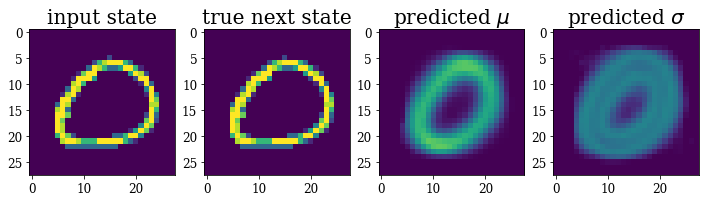

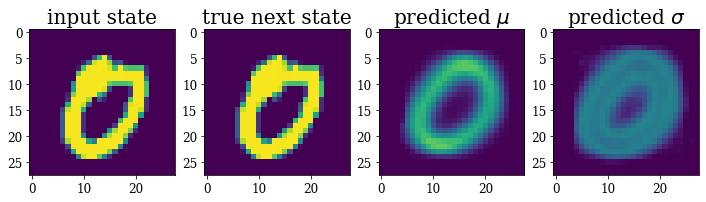

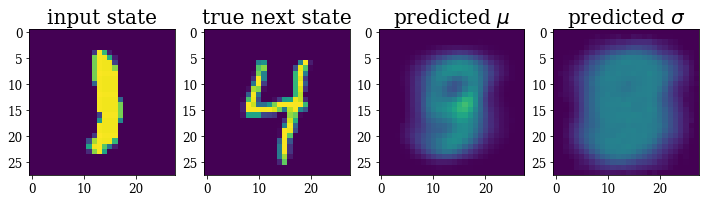

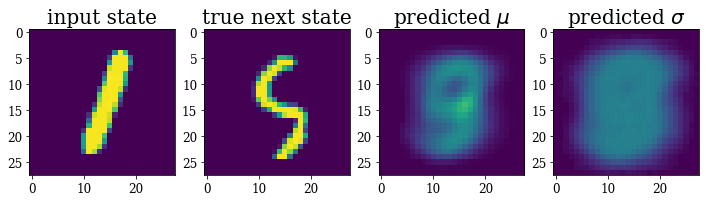

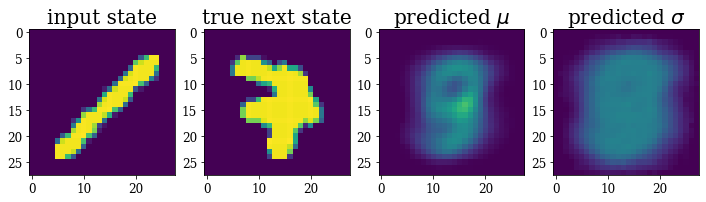

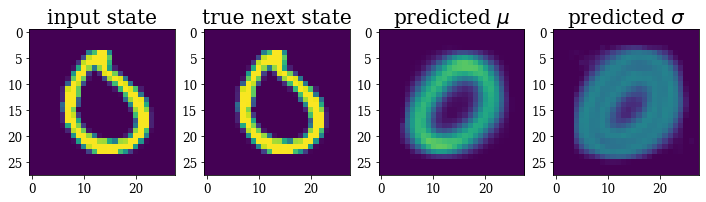

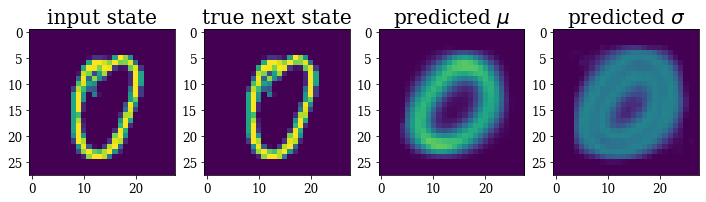

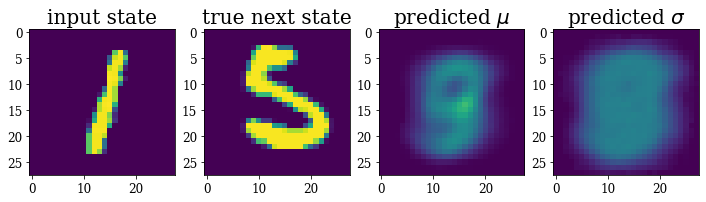

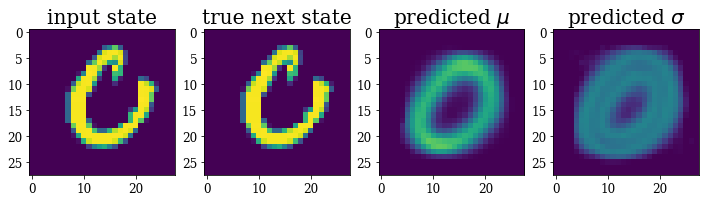

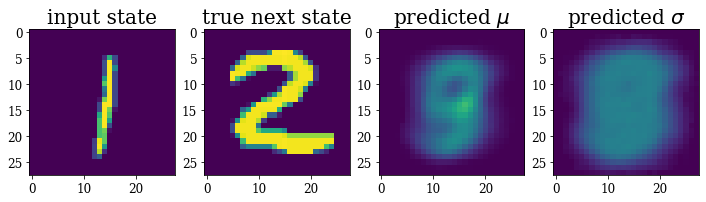


  0%|          | 6/50000 [00:00<15:17, 54.50it/s]

loss 0 -0.84369946
loss 1 -0.8824289



  2%|▏         | 900/50000 [00:16<14:39, 55.85it/s]


  2%|▏         | 1008/50000 [00:18<16:30, 49.48it/s]

loss 0 -0.024208864
loss 1 -0.031241426



  4%|▍         | 1884/50000 [00:33<14:23, 55.74it/s]


  4%|▍         | 2004/50000 [00:36<16:50, 47.48it/s]

loss 0 -0.0093318755
loss 1 -0.012184097



  6%|▌         | 2880/50000 [00:52<14:08, 55.56it/s]


  6%|▌         | 3006/50000 [00:54<16:16, 48.12it/s]

loss 0 -0.0018498214
loss 1 -0.006170767



  8%|▊         | 3882/50000 [01:10<13:55, 55.19it/s]


  8%|▊         | 4008/50000 [01:12<15:22, 49.88it/s]

loss 0 -4.4352757e-05
loss 1 -0.0043740617



 10%|▉         | 4884/50000 [01:28<15:05, 49.83it/s]


 10%|█         | 5010/50000 [01:30<15:00, 49.97it/s]

loss 0 -0.0018051459
loss 1 -0.004577242



 12%|█▏        | 5886/50000 [01:46<13:18, 55.26it/s]


 12%|█▏        | 6006/50000 [01:48<15:21, 47.73it/s]

loss 0 -0.0006497181
loss 1 -0.0018257529



 14%|█▍        | 6882/50000 [02:04<12:49, 56.07it/s]


 14%|█▍        | 7008/50000 [02:06<14:17, 50.14it/s]

loss 0 -0.00026241914
loss 1 -0.0028849342



 16%|█▌        | 7884/50000 [02:22<12:48, 54.79it/s]


 16%|█▌        | 8010/50000 [02:24<14:05, 49.65it/s]

loss 0 -0.00013127152
loss 1 -0.00096521253



 18%|█▊        | 8886/50000 [02:40<12:12, 56.11it/s]


 18%|█▊        | 9006/50000 [02:42<14:08, 48.33it/s]

loss 0 -0.0009109589
loss 1 -0.0024962416



 20%|█▉        | 9882/50000 [02:58<12:03, 55.47it/s]


 20%|██        | 10007/50000 [03:01<15:08, 44.04it/s]

loss 0 -0.002773191
loss 1 -0.0017837121



 22%|██▏       | 10865/50000 [03:16<11:44, 55.52it/s]


 22%|██▏       | 11009/50000 [03:19<12:59, 49.99it/s]

loss 0 -0.00043126495
loss 1 -0.0026221378



 24%|██▎       | 11867/50000 [03:34<11:31, 55.13it/s]


 24%|██▍       | 12005/50000 [03:37<13:06, 48.29it/s]

loss 0 0.00021647125
loss 1 -0.0013753398



 26%|██▌       | 12863/50000 [03:52<11:09, 55.45it/s]


 26%|██▌       | 13007/50000 [03:55<12:18, 50.08it/s]

loss 0 -0.00041629668
loss 1 -0.0013926411



 28%|██▊       | 13865/50000 [04:10<10:53, 55.32it/s]


 28%|██▊       | 14009/50000 [04:13<11:56, 50.20it/s]

loss 0 -0.0005997987
loss 1 -0.0014189255



 30%|██▉       | 14867/50000 [04:29<10:36, 55.20it/s]


 30%|███       | 15005/50000 [04:31<12:06, 48.15it/s]

loss 0 -0.0011881352
loss 1 -0.0012700319



 32%|███▏      | 15862/50000 [04:47<10:27, 54.42it/s]


 32%|███▏      | 16006/50000 [04:49<11:41, 48.44it/s]

loss 0 -0.002886347
loss 1 -0.0003980572



 34%|███▎      | 16864/50000 [05:05<09:52, 55.88it/s]


 34%|███▍      | 17008/50000 [05:07<10:54, 50.42it/s]

loss 0 -0.0014913843
loss 1 -0.0004219904



 36%|███▌      | 17866/50000 [05:23<09:51, 54.35it/s]


 36%|███▌      | 18010/50000 [05:25<10:35, 50.30it/s]

loss 0 -0.0012481646
loss 1 -0.00086066156



 38%|███▊      | 18868/50000 [05:41<09:21, 55.49it/s]


 38%|███▊      | 19006/50000 [05:43<10:53, 47.43it/s]

loss 0 -0.0013143945
loss 1 -0.00084697



 40%|███▉      | 19864/50000 [05:59<08:58, 55.98it/s]


 40%|████      | 20008/50000 [06:02<09:52, 50.59it/s]

loss 0 -0.00097526686
loss 1 -0.00061943225



 42%|████▏     | 20866/50000 [06:17<08:40, 55.97it/s]


 42%|████▏     | 21010/50000 [06:20<09:41, 49.88it/s]

loss 0 -0.0007581921
loss 1 -0.0013896042



 44%|████▎     | 21868/50000 [06:35<08:23, 55.84it/s]


 44%|████▍     | 22006/50000 [06:38<09:46, 47.73it/s]

loss 0 -0.0015141381
loss 1 -0.00014307634



 46%|████▌     | 22864/50000 [06:53<08:04, 55.99it/s]


 46%|████▌     | 23008/50000 [06:56<08:58, 50.11it/s]

loss 0 -0.0016229595
loss 1 -3.5285102e-05



 48%|████▊     | 23866/50000 [07:11<07:51, 55.45it/s]


 48%|████▊     | 24004/50000 [07:14<09:35, 45.15it/s]

loss 0 -0.0022777175
loss 1 -0.00038789154



 50%|████▉     | 24862/50000 [07:29<07:28, 56.02it/s]


 50%|█████     | 25006/50000 [07:32<08:44, 47.68it/s]

loss 0 -0.0023490912
loss 1 -0.001409057



 52%|█████▏    | 25864/50000 [07:47<07:23, 54.38it/s]


 52%|█████▏    | 26008/50000 [07:50<07:56, 50.31it/s]

loss 0 1.3073929e-05
loss 1 -0.0014598542



 54%|█████▎    | 26866/50000 [08:05<06:58, 55.32it/s]


 54%|█████▍    | 27004/50000 [08:08<08:00, 47.87it/s]

loss 0 1.3670773e-06
loss 1 -0.0010937105



 56%|█████▌    | 27862/50000 [08:24<06:39, 55.37it/s]


 56%|█████▌    | 28006/50000 [08:26<07:36, 48.18it/s]

loss 0 1.8268953e-05
loss 1 -0.0008180748



 58%|█████▊    | 28864/50000 [08:42<06:22, 55.30it/s]


 58%|█████▊    | 29008/50000 [08:44<07:06, 49.24it/s]

loss 0 -0.00021701309
loss 1 -0.00100336



 60%|█████▉    | 29866/50000 [09:00<05:58, 56.19it/s]


 60%|██████    | 30010/50000 [09:02<06:37, 50.35it/s]

loss 0 -0.00021952517
loss 1 -0.00049598905



 62%|██████▏   | 30868/50000 [09:18<05:40, 56.25it/s]


 62%|██████▏   | 31006/50000 [09:20<06:36, 47.85it/s]

loss 0 -0.00071805937
loss 1 -0.0006332528



 64%|██████▎   | 31863/50000 [09:36<05:26, 55.48it/s]


 64%|██████▍   | 32007/50000 [09:38<06:02, 49.57it/s]

loss 0 -0.0005616628
loss 1 -0.0008419649



 66%|██████▌   | 32865/50000 [09:54<06:06, 46.77it/s]


 66%|██████▌   | 33008/50000 [09:57<05:44, 49.39it/s]

loss 0 -0.000698632
loss 1 -0.0006708249



 68%|██████▊   | 33866/50000 [10:12<04:49, 55.77it/s]


 68%|██████▊   | 34010/50000 [10:15<05:23, 49.46it/s]

loss 0 -0.0007426344
loss 1 -0.0003565794



 70%|██████▉   | 34868/50000 [10:30<04:33, 55.30it/s]


 70%|███████   | 35006/50000 [10:33<05:11, 48.12it/s]

loss 0 -0.0015504292
loss 1 -0.0015021466



 72%|███████▏  | 35864/50000 [10:48<04:15, 55.32it/s]


 72%|███████▏  | 36008/50000 [10:51<04:38, 50.17it/s]

loss 0 -0.0022045465
loss 1 -0.0011629307



 74%|███████▎  | 36866/50000 [11:06<03:53, 56.15it/s]


 74%|███████▍  | 37010/50000 [11:09<04:18, 50.23it/s]

loss 0 -0.0009666075
loss 1 -0.00086483045



 76%|███████▌  | 37868/50000 [11:25<03:40, 55.00it/s]


 76%|███████▌  | 38006/50000 [11:27<04:14, 47.13it/s]

loss 0 -0.00093433063
loss 1 -0.0020937321



 78%|███████▊  | 38864/50000 [11:43<03:19, 55.70it/s]


 78%|███████▊  | 39008/50000 [11:45<03:41, 49.72it/s]

loss 0 -0.0018971115
loss 1 -0.0012417762



 80%|███████▉  | 39866/50000 [12:01<03:02, 55.56it/s]


 80%|████████  | 40010/50000 [12:03<03:20, 49.81it/s]

loss 0 -0.0030966518
loss 1 -0.0009385361



 82%|████████▏ | 40868/50000 [12:19<02:43, 55.82it/s]


 82%|████████▏ | 41006/50000 [12:21<03:06, 48.14it/s]

loss 0 -0.0029159184
loss 1 -0.0096621765



 84%|████████▎ | 41864/50000 [12:37<02:28, 54.93it/s]


 84%|████████▍ | 42008/50000 [12:40<02:40, 49.64it/s]

loss 0 -0.00077851914
loss 1 -0.0049423412



 86%|████████▌ | 42866/50000 [12:55<02:09, 55.30it/s]


 86%|████████▌ | 43010/50000 [12:58<02:21, 49.32it/s]

loss 0 0.00018407253
loss 1 -0.0017936185



 88%|████████▊ | 43868/50000 [13:13<01:49, 55.91it/s]


 88%|████████▊ | 44006/50000 [13:16<02:05, 47.72it/s]

loss 0 0.00013775357
loss 1 -0.0007376087



 90%|████████▉ | 44864/50000 [13:31<01:31, 56.40it/s]


 90%|█████████ | 45008/50000 [13:34<01:40, 49.79it/s]

loss 0 0.0003299554
loss 1 -0.000106643856



 92%|█████████▏| 45866/50000 [13:50<01:14, 55.52it/s]


 92%|█████████▏| 46004/50000 [13:52<01:26, 46.38it/s]


loss 0 -1.44201595e-05
loss 1 0.0003354394


 94%|█████████▎| 46862/50000 [14:08<00:56, 55.59it/s]


 94%|█████████▍| 47006/50000 [14:10<01:02, 47.88it/s]

loss 0 0.0003050743
loss 1 8.417906e-05



 96%|█████████▌| 47864/50000 [14:26<00:38, 55.83it/s]


 96%|█████████▌| 48008/50000 [14:28<00:39, 50.38it/s]

loss 0 0.00013279225
loss 1 0.00010623548



 98%|█████████▊| 48866/50000 [14:44<00:20, 55.61it/s]


 98%|█████████▊| 49010/50000 [14:47<00:19, 50.59it/s]

loss 0 -0.00012827823
loss 1 0.00032309513



100%|█████████▉| 49868/50000 [15:02<00:02, 55.30it/s]


100%|██████████| 50000/50000 [15:05<00:00, 55.25it/s]


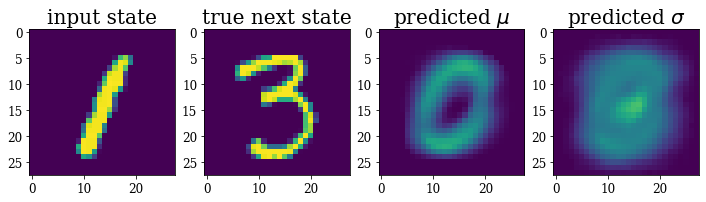

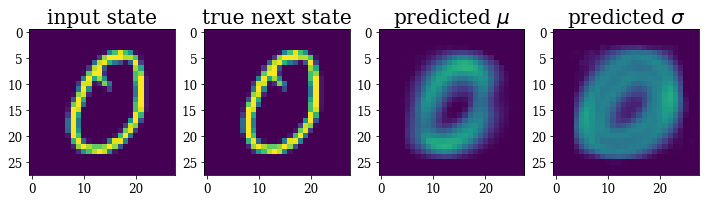

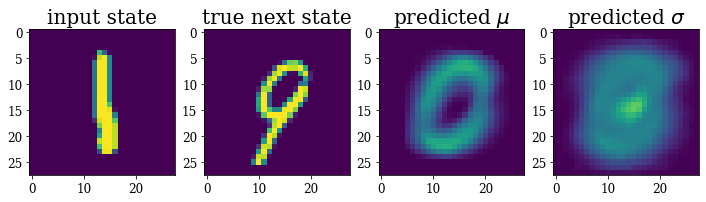

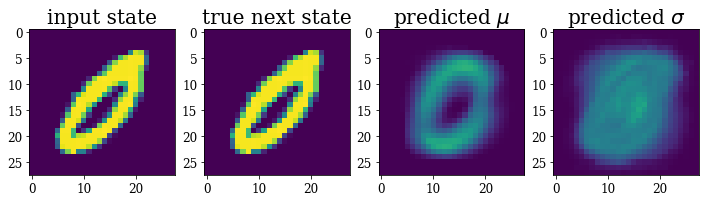

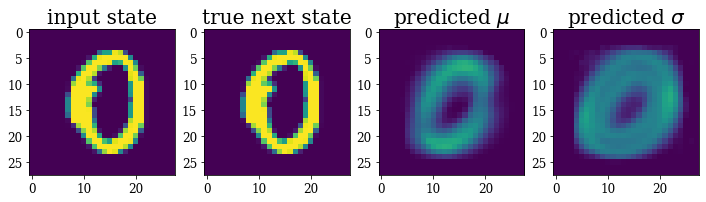

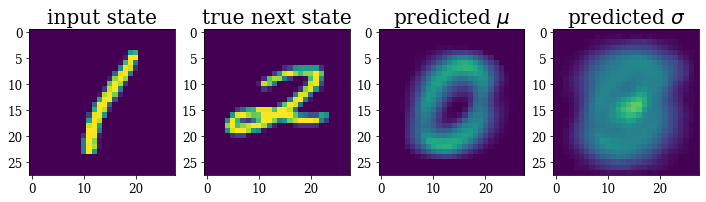

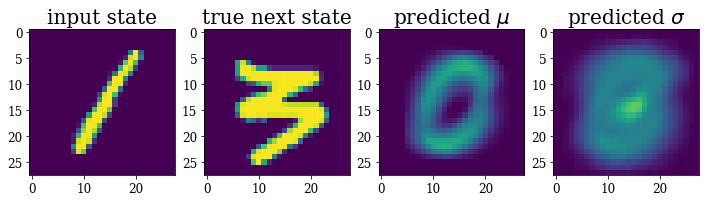

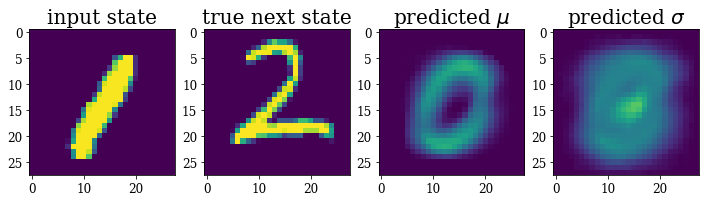

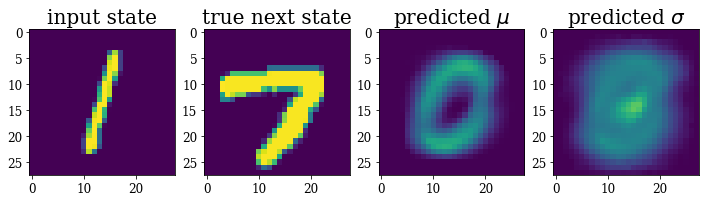

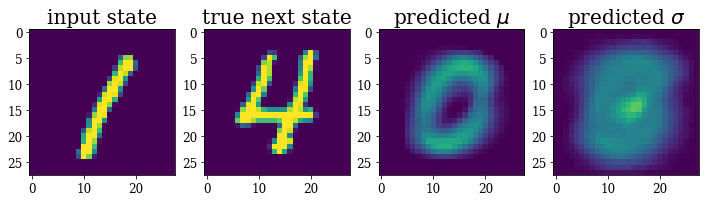

In [11]:
repeats = 2
for repeat in range(repeats):
    model = AleatoricNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    loss_list_aleatoric = []
    loss_buffer = []
    loss_list_0_aleatoric = []
    loss_list_1_aleatoric = []
    loss_buffer_0 = []
    loss_buffer_1 = []

    for update in tqdm(range(int(training_steps))):
        model.train()
        data, target = mnist_env.step()
        data /= 255
        target /= 255
        data = torch.from_numpy(data).float().to(device)
        target = torch.from_numpy(target).float().to(device)
        optimizer.zero_grad()
        mu, log_sigma = model(data)
        mse = F.mse_loss(mu, target, reduction="none")
        loss = torch.mean(torch.exp(-log_sigma) * mse + log_sigma)
        loss.backward()
        optimizer.step()
        loss_buffer.append(torch.mean(mse - torch.exp(log_sigma)))
        if update % checkpoint_loss == 0:
            loss_list_aleatoric.append(torch.mean(torch.stack(loss_buffer)).detach().cpu().numpy())
            loss_buffer = []

        model.eval()
        data, target = mnist_env_zeros.step()
        data /= 255
        target /= 255
        data = torch.from_numpy(data).float().to(device)
        target = torch.from_numpy(target).float().to(device)
        optimizer.zero_grad()
        mu, log_sigma = model(data)
        mse = F.mse_loss(mu, target, reduction="none")
        loss = torch.mean(torch.exp(-log_sigma) * mse + log_sigma)
        loss_buffer_0.append(torch.mean(mse - torch.exp(log_sigma)))
        if update % checkpoint_loss == 0:
            loss_list_0_aleatoric.append(torch.mean(torch.stack(loss_buffer_0)).detach().cpu().numpy())
            print("loss 0", torch.mean(torch.stack(loss_buffer_0)).detach().cpu().numpy())
            loss_buffer_0 = []

        model.eval()
        data, target = mnist_env_ones.step()
        data /= 255
        target /= 255
        data = torch.from_numpy(data).float().to(device)
        target = torch.from_numpy(target).float().to(device)
        optimizer.zero_grad()
        mu, log_sigma = model(data)
        mse = F.mse_loss(mu, target, reduction="none")
        loss = torch.mean(torch.exp(-log_sigma) * mse + log_sigma)
        loss_buffer_1.append(torch.mean(mse - torch.exp(log_sigma)))
        if update % checkpoint_loss == 0:
            loss_list_1_aleatoric.append(torch.mean(torch.stack(loss_buffer_1)).detach().cpu().numpy())
            print("loss 1", torch.mean(torch.stack(loss_buffer_1)).detach().cpu().numpy())
            loss_buffer_1 = []

    data, target = mnist_env.step()
    mu, sigma = model(torch.from_numpy(data).float().to(device)/255)

    for i in range(10):
        w=10
        h=10
        fig=plt.figure(figsize=(12, 12))
        columns = 4
        rows = 1
        fig.add_subplot(rows, columns, 1)
        plt.imshow(data[i].reshape(28, 28)/255, vmin=0, vmax=1)
        plt.title("input state", fontsize=20)

        fig.add_subplot(rows, columns, 2)
        plt.imshow(target[i].reshape(28, 28)/255, vmin=0, vmax=1)
        plt.title("true next state", fontsize=20)

        fig.add_subplot(rows, columns, 3)
        plt.imshow(mu[i].detach().cpu().numpy().reshape(28, 28), vmin=0, vmax=1)
        plt.title("predicted $\mu$", fontsize=20)

        fig.add_subplot(rows, columns, 4)
        plt.imshow(np.sqrt(np.exp((sigma[i].detach().cpu().numpy().reshape(28, 28)))), vmin=0, vmax=1)
        plt.title("predicted $\sigma$", fontsize=20)

        plt.show()
    np.save("lost_list_aleatoric_deterministic_" + str(repeat) + ".npy", loss_list_0_aleatoric)
    np.save("lost_list_aleatoric_stochastic_" + str(repeat) + ".npy", loss_list_1_aleatoric)

(-0.05, 0.01)

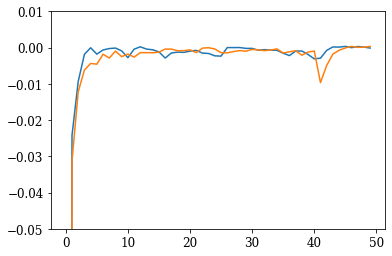

In [12]:
plt.plot(loss_list_0_aleatoric)
plt.plot(loss_list_1_aleatoric)
plt.ylim(-0.05,0.01)

In [ ]:
data, target = mnist_env.step()
mu, sigma = model(torch.from_numpy(data).float().to(device)/255)

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=2000, facecolor='w', edgecolor='k')
title_size = 25
cmap='bone'

for i in range(3):
    w=10
    h=10
    fig=plt.figure(figsize=(18, 18))
    columns = 6
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(data[i].reshape(28, 28)/255, vmin=0, vmax=1, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title(r"Input", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 2)
    plt.imshow(target[i].reshape(28, 28)/255, vmin=0, vmax=1, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title(r"Output", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mu[i].detach().cpu().numpy().reshape(28, 28), vmin=0, vmax=1, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("Pred. $\mu$", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 4)
    plt.imshow(np.sqrt(np.exp((sigma[i].detach().cpu().numpy().reshape(28, 28)))), vmin=0, vmax=1, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("Pred. $\sigma$", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 5)
    plt.imshow(((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28), vmin=0, vmax=1, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("MSE Error", fontsize=title_size)

    fig.add_subplot(rows, columns, 6)
    plt.imshow(((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28) - np.exp(sigma[i].detach().cpu().numpy()).reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("AMA Error", fontsize=title_size)

    plt.show()

 38%|███▊      | 18871/50000 [06:10<09:44, 53.29it/s]

In [ ]:
data, target = mnist_env.step()
mu, sigma = model(torch.from_numpy(data).float().to(device)/255)

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=2000, facecolor='w', edgecolor='k')
title_size = 12
cmap='twilight'
lower_color, higher_color = -1.25, 1.25 

for i in range(3):
    
    w=10
    h=10
    fig=plt.figure(figsize=(18, 18))
    columns = 6
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(data[i].reshape(28, 28)/255, vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title(r"Input", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 2)
    plt.imshow(target[i].reshape(28, 28)/255, vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title(r"Output", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mu[i].detach().cpu().numpy().reshape(28, 28), vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("Pred. $\mu$", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 4)
    plt.imshow(np.sqrt(np.exp((sigma[i].detach().cpu().numpy().reshape(28, 28)))), vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("Pred. $\sigma$", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 5)
    error = ((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28, 28)
    avg_error = np.mean(error)
    plt.imshow(error, vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("MSE Error", fontsize=title_size)

    fig.add_subplot(rows, columns, 6)
    error = ((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28) - np.exp(sigma[i].detach().cpu().numpy()).reshape(28, 28) 
    plt.imshow(error, vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    avg_error = np.mean(error)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("AMA Error", fontsize=title_size)
    #print(((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28) - np.exp(sigma[i].detach().cpu().numpy()).reshape(28, 28))
    #if i == 0:~}
    cbar= plt.colorbar()
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(30)
    plt.show()

In [ ]:
data, target = mnist_env.step()
mu, sigma = model(torch.from_numpy(data).float().to(device)/255)

for i in range(10):
    w=10
    h=10
    fig=plt.figure(figsize=(12, 12))
    columns = 5
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(data[i].reshape(28, 28)/255, vmin=0, vmax=1)
    plt.title("input state", fontsize=20)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(target[i].reshape(28, 28)/255, vmin=0, vmax=1)
    plt.title("true next state", fontsize=20)

    fig.add_subplot(rows, columns, 3)
    plt.imshow(mu[i].detach().cpu().numpy().reshape(28, 28), vmin=0, vmax=1)
    plt.title("predicted $\mu$", fontsize=20)

    fig.add_subplot(rows, columns, 4)
    plt.imshow(np.sqrt(np.exp((sigma[i].detach().cpu().numpy().reshape(28, 28)))), vmin=0, vmax=1)
    plt.title("predicted $\sigma$", fontsize=20)

    fig.add_subplot(rows, columns, 5)
    error = ((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28, 28)
    avg_error = np.mean(error)
    plt.imshow(error, vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    #if i == 0:
    plt.title(str(avg_error), fontsize=title_size)
    plt.show()

In [ ]:
updates = [x * 1000 for x in list(range(len(loss_list_0_aleatoric)))]
plt.plot(updates,loss_list_0_aleatoric,label="Aleatoric Net Less Stochastic")
plt.plot(updates,loss_list_1_aleatoric,label="Aleatoric Net More Stochastic")
plt.plot(updates,loss_list_0,label="Vanilla Net Less Stochastic")
plt.plot(updates,loss_list_1,label="Vanilla Net More Stochastic")
plt.legend(loc="best", fontsize=12)
plt.ylabel("Intrinsic Reward", fontsize=15)
plt.xlabel("Update step", fontsize=15)
plt.ylim(-0.05, 0.2)
plt.title("Noisy MNIST", fontsize=20)

In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=1000, facecolor='w', edgecolor='k')
from matplotlib import rcParams
rcParams['axes.titlepad'] =2 

def load_files_into_arr(list_of_file_paths):
    all_arrs = []
    for a_file in list_of_file_paths:
        all_arrs.append(np.load(a_file))
    return all_arrs

def get_mean_and_std_dev(arr_of_results):
    return np.mean(arr_of_results, axis=0), np.std(arr_of_results, axis=0)

def plot_mean_and_std(mean, std, label):
    assert len(mean) == len(std)
    if "stochastic" in label:
        linestyle="-"
    else:
        linestyle="--"
    if "AMA" in label:
        color="forestgreen"
    else:
        color="darkmagenta"
    plt.plot(list(range(len(mean))), mean, linestyle=linestyle, label=label, color=color)
    x = list(range(len(mean)))
    plt.fill_between(x, (mean-std), (mean+std), alpha=0.2, color=color)

import glob
npy_files = glob.glob("*npy")
aleatoric_stochastic = [file for file in npy_files if "_0" in file and "aleatoric" in file]
aleatoric_deterministic = [file for file in npy_files if "_1" in file and "aleatoric" in file]
vanilla_deterministic = [file for file in npy_files if "aleatoric" not in file and "_0" in file]
vanilla_stochastic = [file for file in npy_files if "aleatoric" not in file and "_1" in file]

list_of_file_lists =[vanilla_stochastic, vanilla_deterministic, aleatoric_stochastic, aleatoric_deterministic,]

legends = [r"MSE stochastic",
           r"MSE deterministic",
           r"AMA stochastic",
           r"AMA deterministic"]

colors = ["darkmagenta", "forestgreen"]
plt.xlim(0, 50)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)

for i, files in enumerate(list_of_file_lists):
    results = load_files_into_arr(files)
    mu, sigma = get_mean_and_std_dev(results)
    plot_mean_and_std(mu, sigma, legends[i])

plt.rc('font', family='serif')
plt.legend(loc="best", fontsize=20)
plt.ylabel("Intrinsic Reward", fontsize=24)
plt.xlabel(r"Update Step $\times 10 ^{3}$", fontsize=24)
plt.ylim(-0.05, 0.2)
plt.title("Noisy MNIST", fontsize=29)